# Ch2. 시계열 모델링 소개
데이터의 순서와 그 상관관계가 중요함
시계열 접근 방식의 우수성: 시간에 따른 관측치 사이의 상관관계가 현재 값을 더 잘 설명함
시간적 상관관계가 있는 데이터: I.I.D. 가정을 위반함

In [15]:
!pip install yfinance

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


ticker = '^GSPC'
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2021, 1, 1)
SP_prices = yf.download(ticker, start=start, end=end, interval='1mo').Close

[*********************100%***********************]  1 of 1 completed


1. 추세
주어진 기간 동안 증가 or 감소하는 일반적인 경향
추세 확인 도구:
(i) 자기상관함수: 시계열의 현재 값과 그로부터 지연(lagged)된 값 사이의 관계 분석
$\hat{p}(h)=\frac{Cov(X_t,X_{t-h})}{Var(X_t)}$

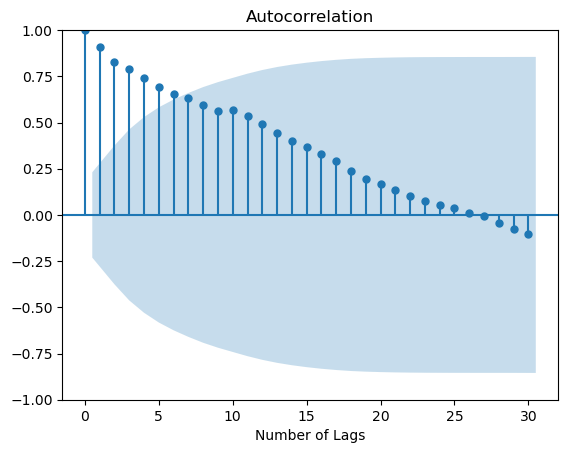

In [17]:
sm.graphics.tsa.plot_acf(SP_prices, lags=30)
import matplotlib.pyplot as plt
plt.xlabel('Number of Lags')
plt.show()

(ii) 부분 자기상관함수: 
$\hat{p}(h)=\frac{Cov(X_t,X_{t-h}|X_{t-1},X_{t-2},..,X_{t-h-1})}{\sqrt{Var(X_t|X_{t-1},..X_{t-h-1})Var(X_{t-h}|X_{t-1},..,X_{t-h-1})}}$
- h: 지연

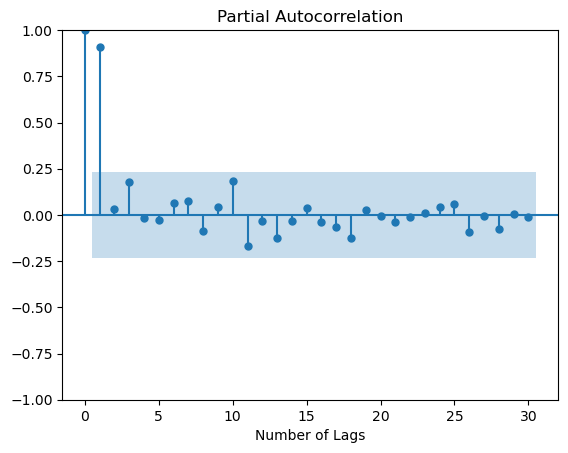

In [18]:
sm.graphics.tsa.plot_pacf(SP_prices, lags=30)
plt.xlabel('Number of Lags')
plt.show()

- 신뢰구간을 나타내는 어두운 영역 외부의 돌출에 초점을 맞춤
- 중간 효과를 분리하는 방식으로 계열의 현재 값과 지연 값 간의 상관관계를 측정함

2. 계절성
주어진 주기 동안 규칙적인 변화가 있는 경우

3. 주기성
추세보다 높은 주기적 변동이 나타날 때 존재함

4. 잔차: 시계열의 불규칙한 구성 요소
- 관측치와 연관된 적합치 사이으 차이
- 정상성(Stationarity): 시계열의 평균, 분산, 공분산과 같은 통계적 속성이 시간이 지남에 따라 변하지 않는 것
(i) 약한 정상성:
- 유한 분산, $E(X^2_t)<\infin, \forall t \in \mathbb{Z}$
- 평균 일정, 시간에만 종속됨 $E(X^2_t)=\mu,t \forall t \in \mathbb{Z}$
- 공분산구조 $\gamma(t,t+h)$는 시간차에만 종속됨: $\gamma(h)=\gamma_h+\gamma(t+h,t)$
- In conclusion, 시계열: 평균이 일정한 유한 분산과 시간차의 함수이 ㄴ공분산 구조 가짐
(ii) 강한 정상성
$(X_{t1},X_{t2},..,X_{tk})$ 결합분포가 $(X_{t1+h},X_{t2+h},...,X_{tk+h})$

- 정상성 필요 이유: (i) 예측가능성

In [19]:
# 비정상성 감지 - 통계적 방법: ADF(Augmented Dickey Fuller) 테스트
stat_test=adfuller(SP_prices)[0:2]
print("The test statistic and p-value of ADF test are {}".format(stat_test))

The test statistic and p-value of ADF test are (np.float64(0.03029512007292569), np.float64(0.9609669053518538))


신뢰구간 95%에서 비정상성

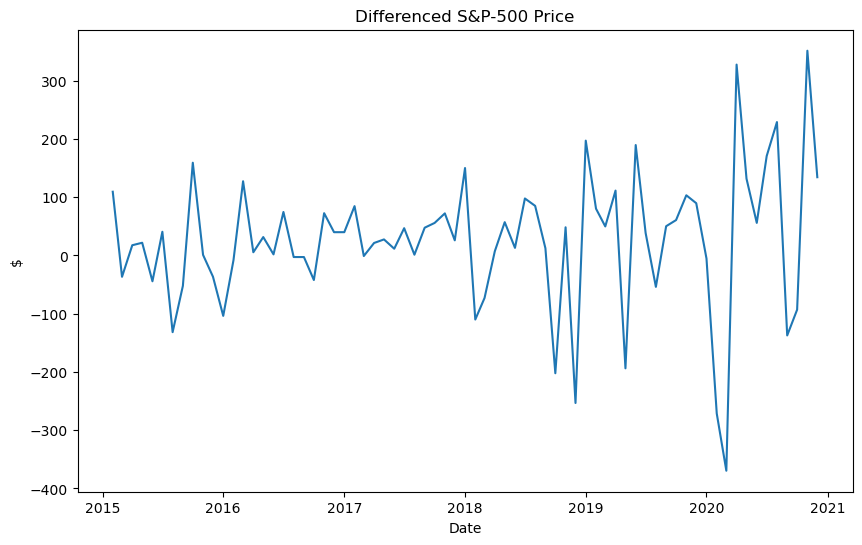

In [20]:
# 차분 -> 정상성 제거에 효율적
diff_SP_price=SP_prices.diff() # 현재 행 값 - 이전 행 값
plt.figure(figsize=(10,6))
plt.plot(diff_SP_price)
plt.title('Differenced S&P-500 Price')
plt.ylabel('$')
plt.xlabel('Date')
plt.show()

- 변동성이 유사한 평균 주변의 변화를 보여줌

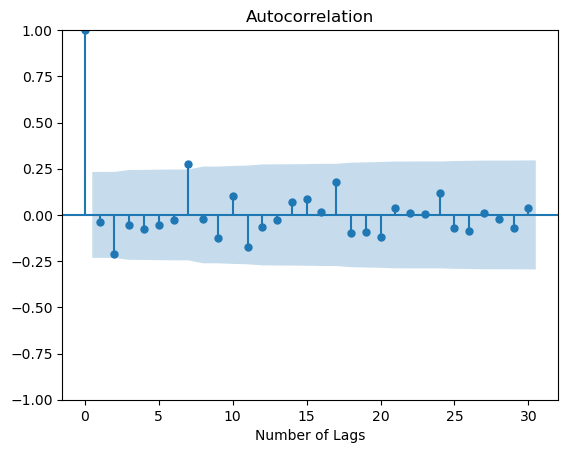

In [21]:
sm.graphics.tsa.plot_acf(diff_SP_price.dropna(),lags=30)
plt.xlabel('Number of Lags')
plt.show()

In [22]:
# 차분 후 ADF 다시 실행
stat_test2=adfuller(diff_SP_price.dropna())[0:2]
print('The test statistic and p-value of ADF test after differencing are {}'.format(stat_test2))

The test statistic and p-value of ADF test after differencing are (np.float64(-7.095105873017086), np.float64(4.3095548146405375e-10))


- 매우 낮은 p-값: 정상 상태임

In [23]:
!pip install fredapi

In [24]:
from fredapi import Fred
fred = Fred(api_key='8433b88f3d5493358ef5e78c579273e4')
energy = fred.get_series("CAPUTLG2211A2S", 
                         observation_start="2010-01-01", 
                         observation_end="2020-12-31")

- 계절 지수 = $\frac{계절 시계열 값}{계절 평균}$

In [25]:
# 분기별 에너지 이용 평균 계산
seasonal_index=energy.resample('Q').mean() # 재샘플링: 시간 간격 변경할 때 사용
# 계절성 분석 수행하는 연도 정의
dates=energy.index.year.unique()
deseasonalized=[]
# 계절 지수 공식의 분자 계산
for i in dates:
    for j in range(1, 13):
        # Pandas 시계열 데이터: 문자열로 연도 -> 해당 연도 뽑아줌
        # 그 중에서 month==j 인 행
        deseasonalized.append((energy[str(i)][energy[str(i)].index.month==j]))
concat_deseasonalized=np.concatenate(deseasonalized)

C:\Users\82103\AppData\Local\Temp\ipykernel_14176\2293318698.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  seasonal_index=energy.resample('Q').mean() # 재샘플링: 시간 간격 변경할 때 사용


In [26]:
deseason_energy=[]
for i,s in zip(range(0,len(energy),3), range(len(seasonal_index))):
    # 계절 지수 계산
    deseason_energy.append(concat_deseasonalized[i:i+3]/seasonal_index.iloc[s])
concat_deseason_energy=np.concat(deseason_energy)
deseason_energy=pd.DataFrame(concat_deseason_energy,index=energy.index)
deseason_energy.columns=['Deseasonalized Energy']

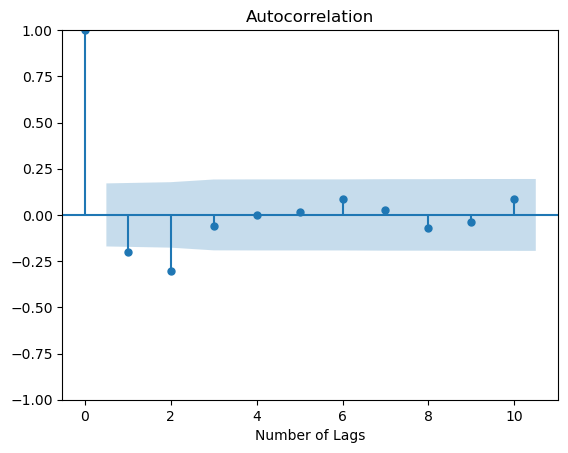

In [27]:
sm.graphics.tsa.plot_acf(deseason_energy, lags=10)
plt.xlabel('Number of Lags')
plt.show()

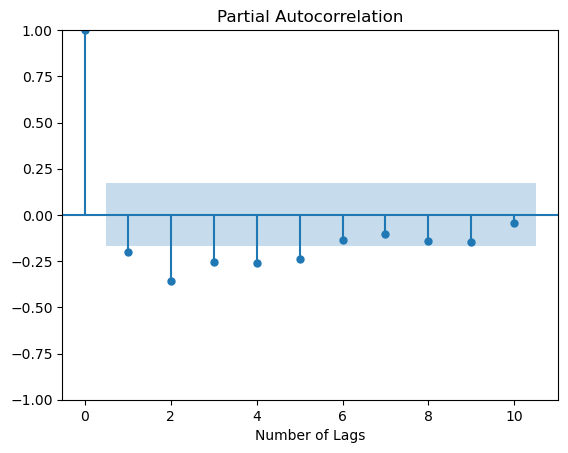

In [28]:
sm.graphics.tsa.plot_pacf(deseason_energy,lags=10)
plt.xlabel('Number of Lags')
plt.show()

[시계열 모델]
변수 식별 & 추정 과정 거친 후 모형 실행
$\\$
[백색 잡음]
$\\ \epsilon _t \sim WN(0,\sigma^2_\epsilon)$
$\\Corr(\epsilon_t,\epsilon_s)=0,\ \forall t!=s$

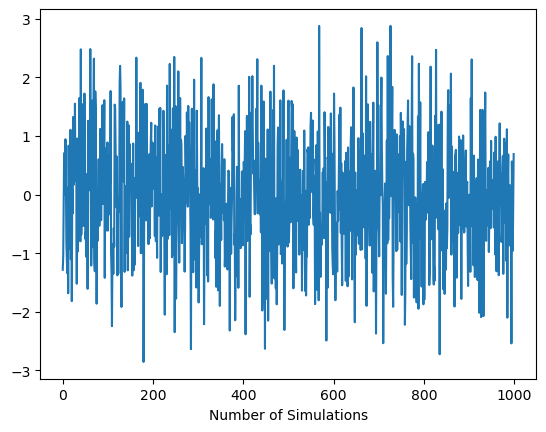

In [30]:
mu=0
std=1
WN=np.random.normal(mu, std, 1000)

plt.plot(WN)
plt.xlabel('Number of Simulations')
plt.show()

[최적의 지연 수 알아내기]
- ACF / PACF / 정보기준
- 정보기준(AIC) : 최대 우도 원칙(MLE)의 확장으로 도입됨
$\\ AIC = -2ln(최대우도) + 2d$

1. 이동 평균 모형
$\\ MA(q)=\epsilon_t+\alpha_1\epsilon_{t-1}+...+\alpha_q\epsilon_{t-q}$

In [52]:
ticker=['AAPL','MSFT']
start=datetime.datetime(2019,1,1)
end=datetime.datetime(2021,1,1)
stock_prices=yf.download(ticker,start,end,interval='1d').Close
stock_prices=stock_prices.dropna()

[*********************100%***********************]  2 of 2 completed


In [32]:
for i in ticker:
    stat_test=adfuller(stock_prices[i])[0:2]
    print("{}| ADF Stastistic: {}, P-value: {}".format(i, stat_test[0], stat_test[1]))

AAPL| ADF Stastistic: 0.3193991408979412, P-value: 0.9782172097240536
MSFT| ADF Stastistic: -0.7445067344604752, P-value: 0.8348821247425076


In [ ]:
diff_stock_prices=stock_prices.diff().dropna() # 차분

split=int(len(diff_stock_prices['AAPL'])*0.95)

for i in ticker:
    diff_train=diff_stock_prices[i].iloc[:split]
    diff_test=diff_stock_prices[i].iloc[split:]
    diff_train.to_csv('diff_train_'+i+'.csv')
    diff_test.to_csv('diff_test_'+i+'.csv')

In [58]:
# train = [AAPL, MSFT], test = "
train=[]
test=[]
for i in ticker:
    train.append(pd.read_csv('diff_train_'+i+'.csv', index_col=0))
    test.append(pd.read_csv('diff_test_'+i+'.csv',index_col=0))

for i in range(2):
    train[i].index=pd.to_datetime(train[i].index)
    test[i].index=pd.to_datetime(test[i].index)


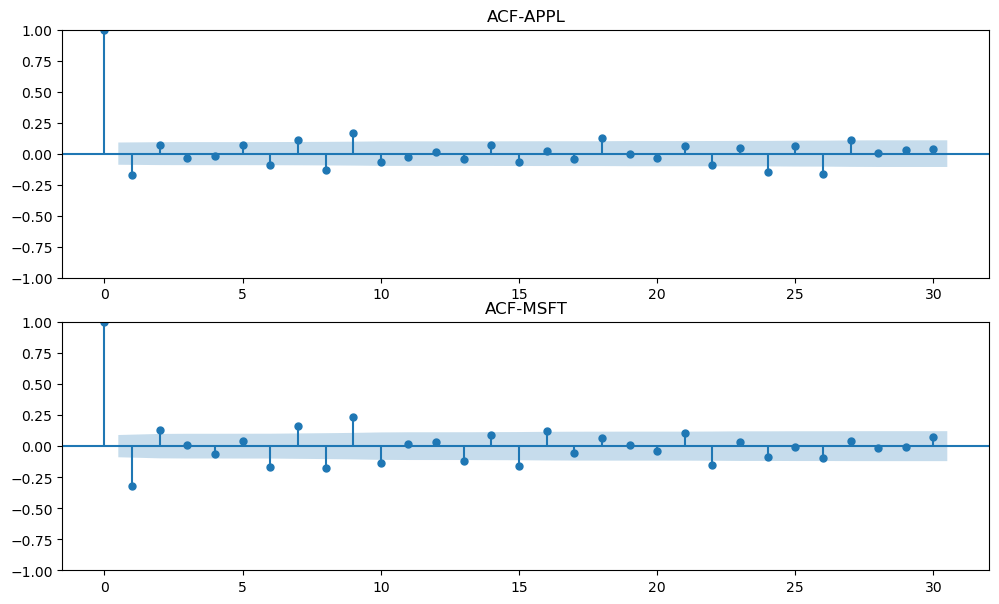

In [59]:
fig, ax=plt.subplots(2,1, figsize=(10,6))
plt.tight_layout()
sm.graphics.tsa.plot_acf(train[0],lags=30,ax=ax[0],title='ACF-APPL')
sm.graphics.tsa.plot_acf(train[1],lags=30,ax=ax[1],title='ACF-MSFT')
plt.show()

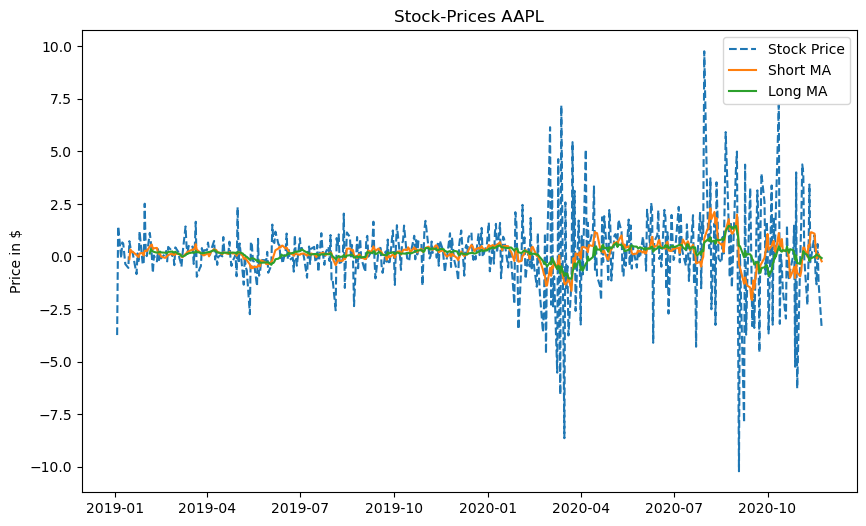

In [ ]:
# AAPL: 일부 지연에서 상당한 돌파선 존재 -> 단기 MA 모델에서 지연 9 선택

short_moving_average_apple=train[0].rolling(window=9).mean()
long_moving_average_apple=train[0].rolling(window=22).mean()


fig, ax=plt.subplots(figsize=(10,6))
ax.plot(train[0].loc[start:end].index,train[0].loc[start:end],label='Stock Price',linestyle='--')
ax.plot(short_moving_average_apple.loc[start:end].index,short_moving_average_apple.loc[start:end],label='Short MA',linestyle='solid')
ax.plot(long_moving_average_apple.loc[start:end].index,long_moving_average_apple.loc[start:end],label='Long MA',linestyle='solid')
ax.legend(loc='best')
ax.set_ylabel('Price in $')
ax.set_title('Stock-Prices AAPL')
plt.show()


# 2. 자기회귀 모델
$\\ AR(p): X_t = c+ \alpha_1X_{t-1}+\alpha_2X_{t=2}+...+\alpha_pX_{t-p}+\epsilon_t$
- p차까지의 과거 값이 $X_t$에 대해 설명력을 가짐
- MA: 무한 AR 프로세스로 작성 가능 -> 정상 공분산 구조, 확정적 부분 및 가역 MA 과정
$\\ Thus,\ |\alpha|<1$ 가정:
$\\ X_t = \alpha X_{t-1}-\alpha^2X_{t-2}+...-(-\alpha)^n\epsilon_{t-n}$
$\\ \rarr \alpha^n\epsilon_{t-n}=\epsilon_t-\sum^{n-1}_{i=0}\alpha^iX_{t-i}$
$\\ \rarr n \rarr \infin,\ \epsilon_t=\sum^\infin_{i=0}\alpha^iX_{t-i}$
- 부분 ACF: AR 모델에서 최적의 차수 찾는 데 유용함

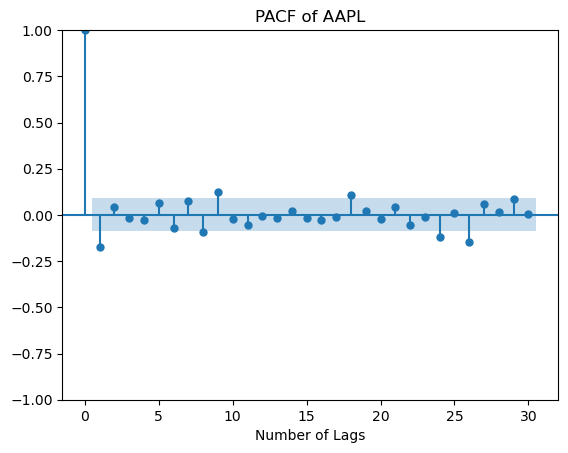

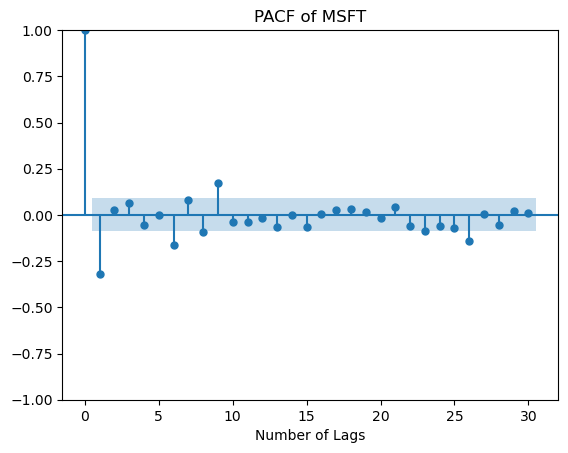

In [61]:
sm.graphics.tsa.plot_pacf(train[0], lags=30)
plt.title("PACF of AAPL")
plt.xlabel("Number of Lags")
plt.show()

sm.graphics.tsa.plot_pacf(train[1], lags=30)
plt.title("PACF of MSFT")
plt.xlabel("Number of Lags")
plt.show()

In [62]:
# AR 모델링
from statsmodels.tsa.ar_model import AutoReg
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# AR(29) 계수 추정
ar_appl=AutoReg(train[0].values,lags=29)
ar_fitted_appl=ar_appl.fit() 

In [ ]:
# start 전까지는 값 존재, start 부터 예측
ar_predictions_appl=ar_fitted_appl.predict(start=len(train[0]),end=len(train[0])+len(test[0])-1,dynamic=False) 

In [66]:
ar_predictions_appl=pd.DataFrame(ar_predictions_appl)
ar_predictions_appl.index=test[0].index

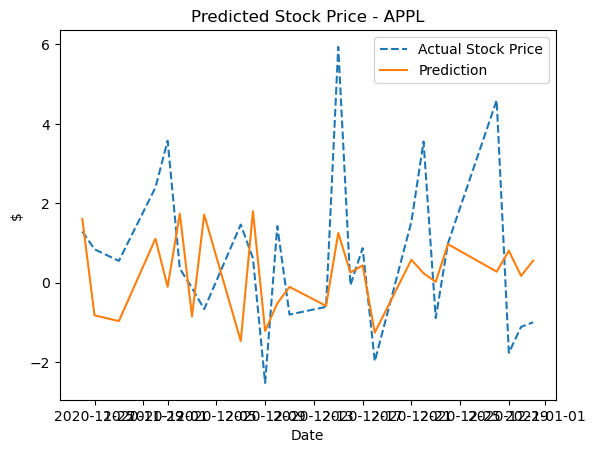

In [72]:
plt.plot(test[0],label='Actual Stock Price',linestyle='--')
plt.plot(ar_predictions_appl, linestyle='solid',label='Prediction')
plt.title('Predicted Stock Price - APPL')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()

# 3. 자기회귀 통합 이동 평균 모델
ARIMA: 시계열의 과거값 + 백색 잡음의 함수
$\\ ARIMA(p,1,q): X_t=\alpha_1dX_{t-1}+\alpha_2dX_{t-2}+...+\epsilon_t+\beta_1\epsilon_{t-2}+...+\beta_q\epsilon_{t-q}$

In [76]:
from statsmodels.tsa.arima.model import ARIMA

In [77]:
arima_appl=ARIMA(train[0],order=(9,1,9))
arima_fit_appl=arima_appl.fit()
arima_predict_appl=arima_fit_appl.predict(start=len(train[0]),end=len(train[0])+len(test[0])-1,dynamic=False)
arima_predict_appl=pd.DataFrame(arima_predict_appl)
arima_predict_appl.index=test[0].index

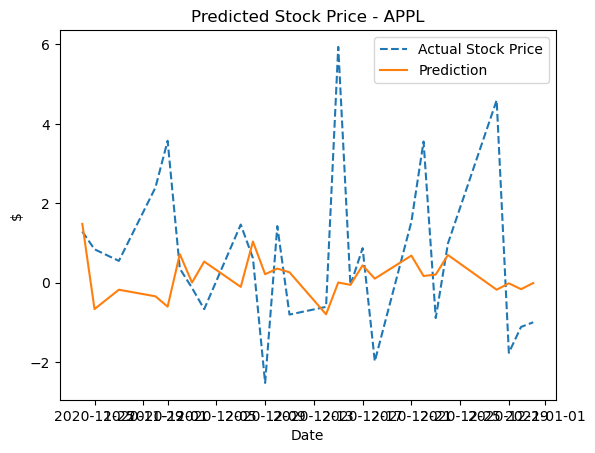

In [78]:
plt.plot(test[0],label='Actual Stock Price',linestyle='--')
plt.plot(arima_predict_appl, linestyle='solid',label='Prediction')
plt.title('Predicted Stock Price - APPL')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()

In [79]:
# AIC 결과: (4,0,4) 도출
import itertools

In [80]:
p = q = range(0,9)
d = range(3)
pdq=list(itertools.product(p,d,q))
arima_results_appl=[]
for param_set in pdq:
    try:
        arima_appl=ARIMA(train[0],order=param_set)
        arima_fitted_appl=arima_appl.fit()
        arima_results_appl.append(arima_fitted_appl.aic)
    except:
        continue
recommended=pdq[arima_results_appl.index(min(arima_results_appl))] # (4,1,4)

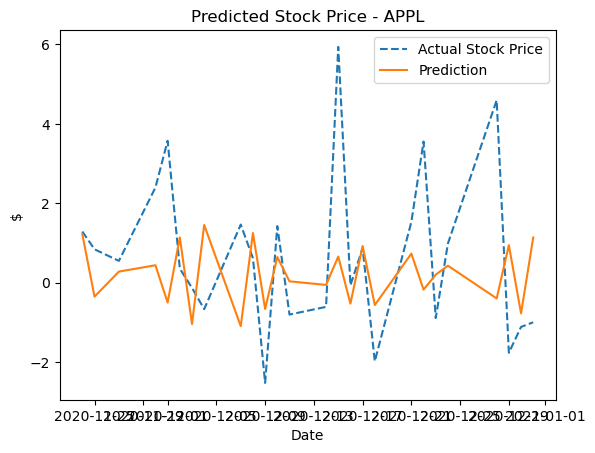

In [81]:
arima_appl=ARIMA(train[0],order=(4,1,4))
arima_fit_appl=arima_appl.fit()
arima_predict_appl=arima_fit_appl.predict(start=len(train[0]),end=len(train[0])+len(test[0])-1,dynamic=False)
arima_predict_appl=pd.DataFrame(arima_predict_appl)
arima_predict_appl.index=test[0].index

plt.plot(test[0],label='Actual Stock Price',linestyle='--')
plt.plot(arima_predict_appl, linestyle='solid',label='Prediction')
plt.title('Predicted Stock Price - APPL')
plt.legend(loc='best')
plt.xlabel('Date')
plt.ylabel('$')
plt.show()